Remise électronique sur ZoneCours au plus tard le **22 février à 23h55** de:

* Ce Jupyter notebook (.ipynb) en guise de rapport, une fois les réponses ajoutées.
* **Tous** les fichiers *.py* nécessaires pour l'exécution du notebook

Le rapport **doit**:

* être en format .ipynb (des points seront enlevés pour tout autre format).
* inclure le numéro de matricule de tous les membres de l'équipe dans la première cellule (i.e. remplacez ces consignes)
* répondre aux questions et discuter des résultats à l'aide de tables, graphiques, et cellules markdown

Barème:

* **40%** Exactitude des résultats
* **25%** Discussions complètes et **concises** (cellules ``markdown'')
* **20%** Concision du notebook (.ipynb avec minimum de code) et clarté des graphiques
* **15%** Clarté du code (.py)

Dans les tables, présentez 4 décimales après le point.

# Question 1

Une action ne versant pas de dividende cote présentement à 100. Le taux sans risque à 1 mois est de 5%. Vous observez sur le marché les prix suivants pour des puts européens venant à maturité dans 1 mois:


In [1]:
from utils import *

In [2]:
info = get_info()
info

,Strike,Put
0,80.0,0.1900
1,90.0,0.6907
2,97.5,1.6529
3,102.5,3.3409
4,110.0,9.8399
5,120.0,19.5805


Quelles sont les volatilités implicites ('IV') de ces puts? Tracez le graphe des ces IV en fonction de $K/S$ et discutez brièvement.


On commence par poser les données du problème :

- Le sous-jacent qui ne verse pas de dividendes côte actuellement à 100$
- Expiration du put option dans un mois, c'est-à-dire 1/12 d'année.
- Taux sans risque à un mois est de 5%

In [3]:
S0 = 100.0
T = 1/12
r = 0.05

Avant de pouvoir trouver les volatilités implicites ("IV") de ces puts, nous devons définir le modèle de Black-Merton-Scholes pour un put.

In [4]:
compute_put_option(sigma=0.2, S0=S0, K=102.5, T=T, r=r)

3.509230952965808

In [5]:
sigma = compute_implied_volatility_by_bisection(S0=S0, K=102.5, T=T, r=r, Put=3.3409)

In [6]:
compute_put_option(sigma=sigma, S0=S0, K=102.5, T=T, r=r)

3.3408995112149142

In [7]:
results = pd.DataFrame()

In [8]:
results["Sigma"] = compute_implicit_vol_array(S0=S0, K=info['Strike'].values, T=T, r=r, Put=info['Put'].values)

In [9]:
results["Put BMS"] = compute_put_option(sigma=results["Sigma"].values, S0=S0, K=info['Strike'].values, T=T, r=r)
results["Put"] = info['Put']

In [10]:
results["Error"] = results["Put BMS"] - results["Put"]
results

,Sigma,Put BMS,Put,Error
0,0.451208,0.190000,0.1900,4.914754e-07
1,0.352293,0.690701,0.6907,9.555129e-07
2,0.253404,1.652900,1.6529,6.482257e-08
3,0.184501,3.340900,3.3409,-4.887851e-07
4,0.235599,9.839900,9.8399,-1.981998e-07
5,0.306697,19.580500,19.5805,2.192922e-08


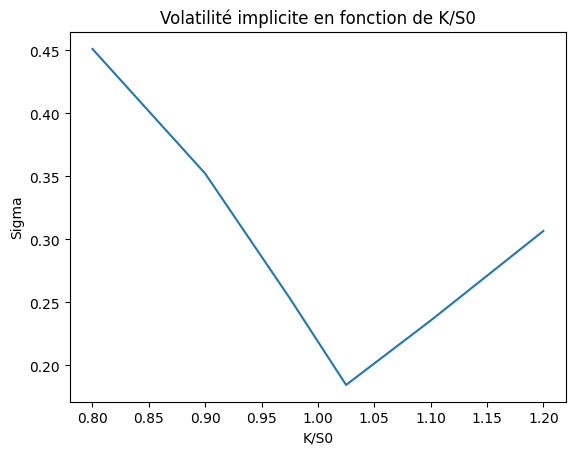

In [16]:
results["K/S0"] = info['Strike']/S0

plt.plot(results["K/S0"], results['Sigma'])
plt.xlabel("K/S0")
plt.ylabel("Sigma")
plt.title("Volatilité implicite en fonction de K/S0")
plt.show()

# Question 2

Vous vous intéressez à ces options parce que vous avez, d'autre part,
émis des produits structurés contenant des puts de même strikes, mais permettant un exercice à tout moment d'ici la maturité. Pour chacun de ces strike, vous désirez donc utiliser un arbre CRR afin de valoriser l'option américaine correspondante.

En premier lieu, vous désirez donc étudier la convergence de votre arbre vers le prix BMS pour les européennes observées sur le marché. Pour des valeurs de $N$ allant de 2 à 100 (`range(2,101)`), tracer, dans une figure
`
    fig, axes = plt.subplots(3, 2, figsize=(15,20))
`
avec une sous-figure par strike,

* Le prix CRR obtenu pour chaque $N$
* Une ligne horizontale traitillée au prix de marché
* Deux ligne horizontales pointillées à $\pm$1 bp du prix de marché

Discutez brièvement de la qualité de la convergence.

In [12]:
CRR_Tree(S=S0, K=info['Strike'].iloc[1], T=T, r=r, sigma=results['Sigma'].iloc[1], N=100)

0.6896011738623822

In [13]:
N_range = np.arange(2, 101)

In [14]:
CRR_values = np.array([[CRR_Tree(S=S0, K=info['Strike'].iloc[i], T=T, r=r, sigma=results['Sigma'].iloc[i], N=N) for N in N_range] for i in range(len(info))]).T
columns = [f"Put_{i}" for i in range(len(info))]
df_crr = matrix_to_dataframe(CRR_values, columns=columns)

In [15]:
df_crr

,Put_0,Put_1,Put_2,Put_3,Put_4,Put_5
0,0.000000,0.000000,0.000000,1.243141,4.977354,11.623474
1,0.000000,0.000000,0.603463,2.001124,7.363181,15.262449
2,0.000000,0.000000,1.110630,2.747304,8.504583,17.258852
3,0.000000,0.434265,1.258093,2.864910,9.049485,18.386373
4,0.000000,0.502965,1.547709,3.214704,9.479427,18.956770
...,...,...,...,...,...,...
94,0.189765,0.686172,1.657609,3.343292,9.837722,19.577964
95,0.186304,0.694105,1.654605,3.342323,9.840408,19.579741
96,0.190098,0.688031,1.657129,3.343665,9.836343,19.578754
97,0.185439,0.693518,1.655110,3.341736,9.840680,19.579386
